<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

In [2]:
RANDOM = 465

In [3]:
data = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=True)

In [4]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


In [6]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
data.sample(5, random_state = 455)

,num_orders
datetime,
2018-08-07 21:00:00,101
2018-07-12 09:00:00,108
2018-04-27 03:00:00,117
2018-04-28 23:00:00,107
2018-04-03 20:00:00,37


In [8]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


**Вывод**

Представлены данные по количеству заказов такси по датам. Сгруппируем их по каждому часу суммарно.

## Анализ

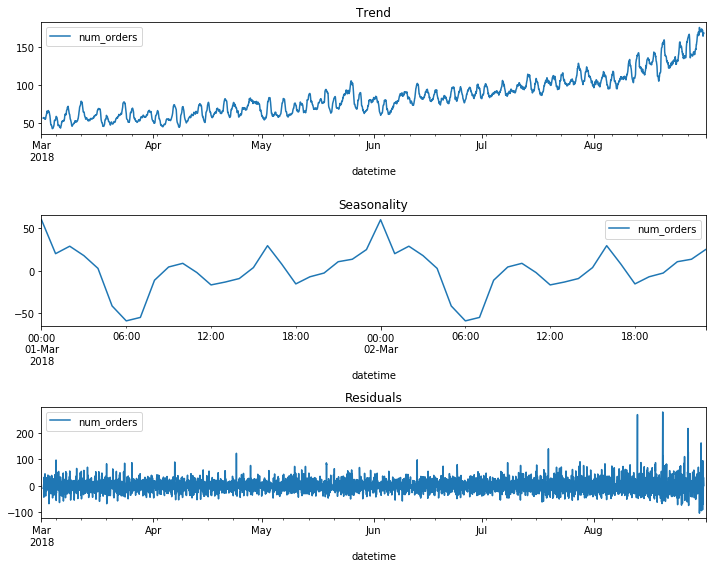

In [9]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(10, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

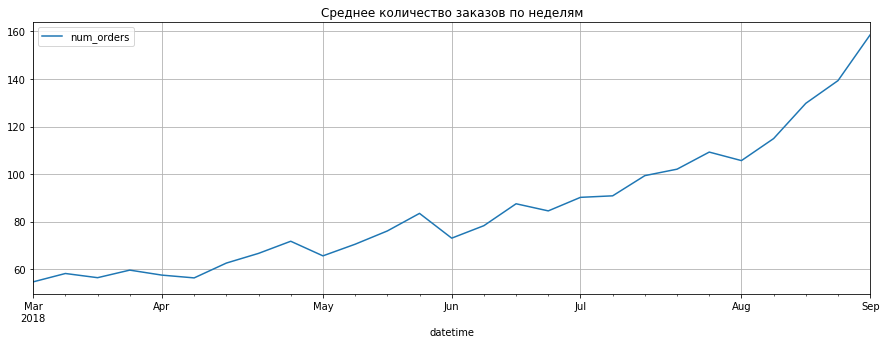

In [10]:
data.resample('W-MON').mean().plot(figsize=(15, 5), grid=True)
plt.title('Среднее количество заказов по неделям')
plt.show()

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['prev_hour_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 1, 24)

data.head()

,num_orders,dayofweek,hour,prev_hour_1,rolling_mean
datetime,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN
2018-03-01 02:00:00,71,3,2,85.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,NaN


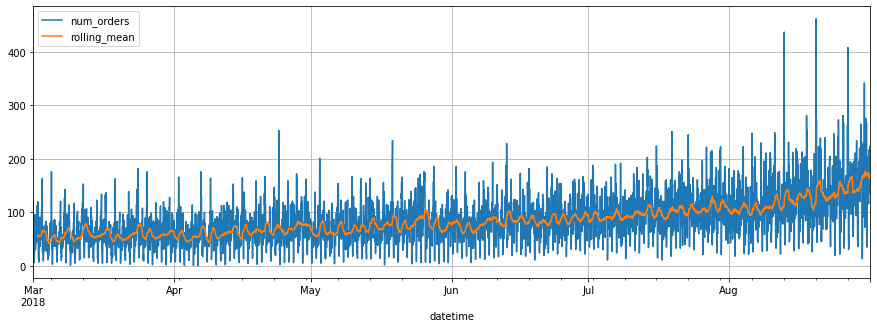

In [12]:
data[['num_orders','rolling_mean']].plot(figsize=(15, 5), grid=True)
plt.show()

**Вывод**

График сезонности показывает, что пиковое число заказов происходит в полночь и спадает к 6 утра. Следующие пиковые значения происходят в 10 и 16 часов.  
Больше всего заказов в неделю с среднем приходится на конец недели за исключением конца месяца.  

В качестве признаков выделим день недели и час суток, предыдущий час, скользящее среднее за сутки.

## Обучение

In [13]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
print('Размер обучающей выборки:', train.shape)
print('С:', train.index.min(), 'по', train.index.max())
print('Размер тестовой выборки:', test.shape)
print('С:', test.index.min(), 'по', test.index.max())

Размер обучающей выборки: (3950, 5)
С: 2018-03-02 00:00:00 по 2018-08-13 13:00:00
Размер тестовой выборки: (442, 5)
С: 2018-08-13 14:00:00 по 2018-08-31 23:00:00


In [14]:
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test= test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

In [15]:
def feature_imp(model_attr, columns):
    importances = model_attr
    indices = np.argsort(importances)
    
    plt.figure(figsize=(10,7))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [columns[i] for i in indices])
    plt.grid()
    plt.show()

In [16]:
def true_pred_plot(true, pred):
    plt.figure(figsize=(15, 5))
    all_results = pd.concat([true, pd.Series(data=pred, index=true.index)],
                        keys=['y_true', 'y_pred'], axis=1)
    plt.grid()
    plt.plot(all_results['2018-05-01':'2018-05-03'])
    plt.show()

**LinearRegression**

In [17]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

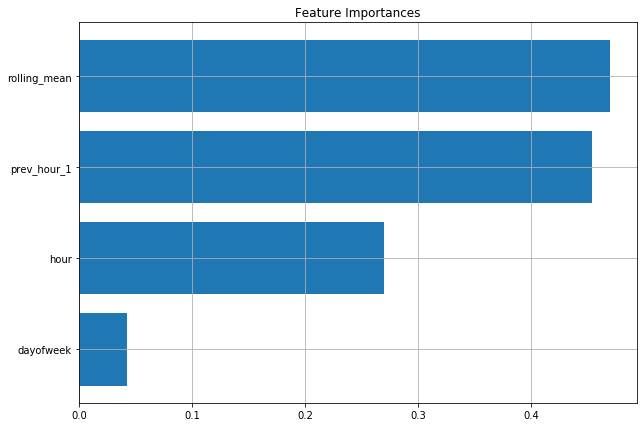

In [18]:
feature_imp(model_lr.coef_, X_train.columns)

In [19]:
predicted_train_lr = model_lr.predict(X_train)
rmse_lr_train = mean_squared_error(y_train, predicted_train_lr) ** 0.5
print('RMSE:', rmse_lr_train)

RMSE: 30.90708535540955


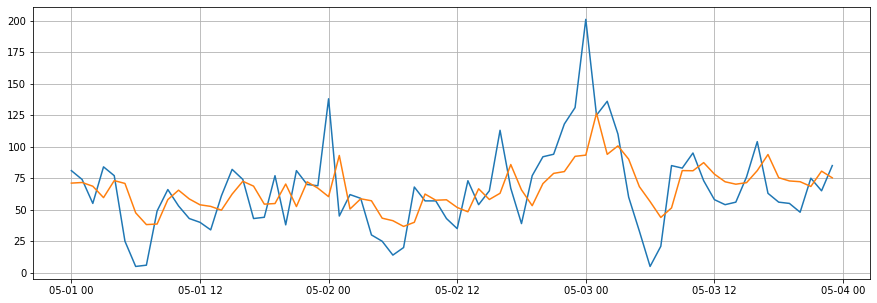

In [20]:
true_pred_plot(y_train, predicted_train_lr)

**RandomForestRegressor**

In [21]:
model_rf = RandomForestRegressor(n_estimators=75,
                                 max_depth=15,
                                 bootstrap=True,
                                 min_samples_leaf=3,
                                 random_state=RANDOM)
model_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=75,
                      n_jobs=None, oob_score=False, random_state=465, verbose=0,
                      warm_start=False)

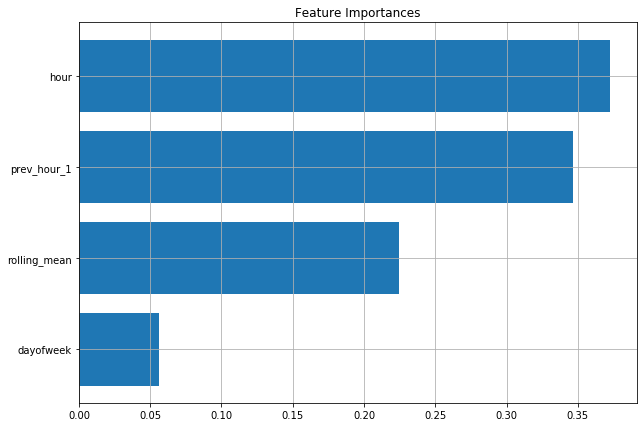

In [22]:
feature_imp(model_rf.feature_importances_, X_train.columns)

In [23]:
predicted_train_rf = model_rf.predict(X_train)
rmse_rf_train = mean_squared_error(y_train, predicted_train_rf) ** 0.5
print('RMSE:', rmse_rf_train)

RMSE: 14.63819127221155


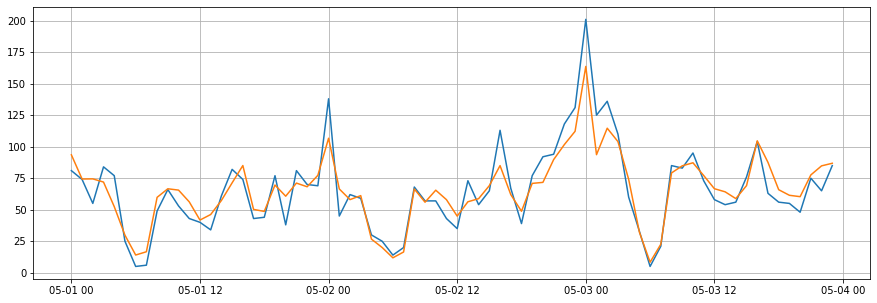

In [24]:
true_pred_plot(y_train, predicted_train_rf)

**XGBoost**

In [25]:
xgb = XGBRegressor(n_estimators=3000,
                   max_depth=5, learning_rate=0.01,
                   min_child_weight=2,
                   random_state=RANDOM)
xgb.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="rmse",
        early_stopping_rounds=10,
        verbose=False)

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[21:45:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=2, missing=None, n_estimators=3000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=465,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

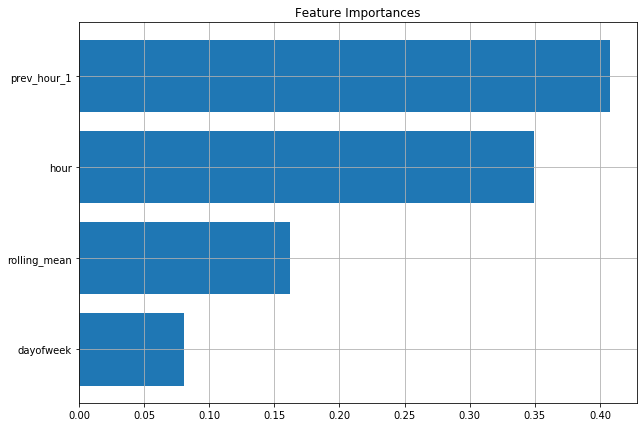

In [26]:
feature_imp(xgb.feature_importances_, X_train.columns)

In [27]:
predicted_train_xgb = xgb.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, predicted_train_xgb) ** 0.5
print('RMSE:', rmse_xgb_train)

RMSE: 18.146142802310298


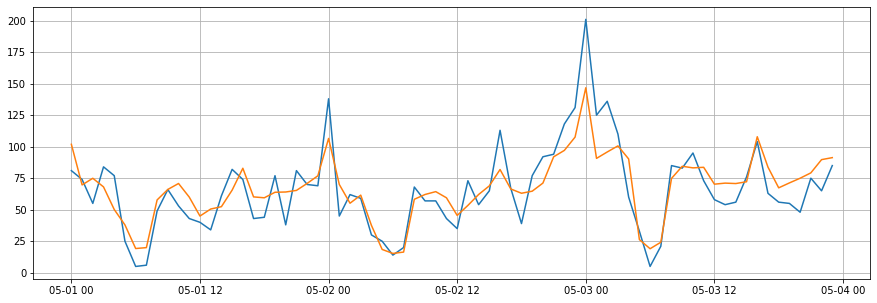

In [28]:
true_pred_plot(y_train, predicted_train_xgb)

**LightGBM**

In [29]:
params_gbm = {
    'metric': ['l1', 'l2'],
    'learning_rate': 0.01,
    'max_depth': 10,
    "n_estimators": 3000,
    'num_leaves': 40,
    'random_state': RANDOM
    }

gbm = lgb.LGBMRegressor(**params_gbm)

In [30]:
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="l1",
        early_stopping_rounds=10,
        verbose=False)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=10,
              metric=['l1', 'l2'], min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=3000, n_jobs=-1, num_leaves=40,
              objective=None, random_state=465, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

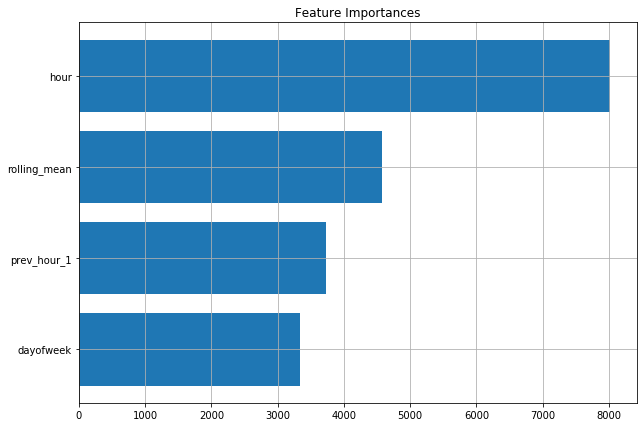

In [31]:
feature_imp(gbm.feature_importances_, X_train.columns)

In [32]:
predicted_train_gbm = gbm.predict(X_train, num_iteration=gbm.best_iteration_)
rmse_gbm_train = mean_squared_error(y_train, predicted_train_gbm) ** 0.5
print('RMSE:', rmse_gbm_train)

RMSE: 18.553870506573418


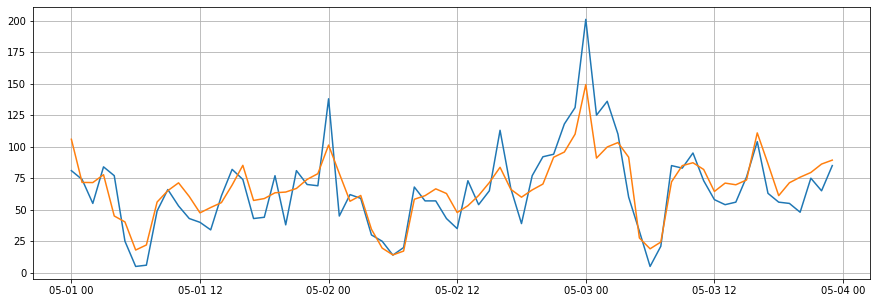

In [33]:
true_pred_plot(y_train, predicted_train_gbm)

**Предыдущее значение**

In [34]:
pred_previous_train = y_train.shift()
pred_previous_train.iloc[0] = y_train.iloc[-1]
pred_previous_train = mean_squared_error(y_train, pred_previous_train) ** 0.5
print("RMSE:", pred_previous_train)

RMSE: 36.183526568546476


**Вывод**

При обучении у всех моделей самыми важными признаками являются предыдущий час и данный час в сутках.  
Наибольшие ошибки в предсказаниях моделей в максимальных значениях в полночь.  
Лучшее RMSE у LightGBM, XGBoost и RandomForestRegressor на тренировочной выборке.

## Тестирование

**LinearRegression**

In [35]:
predicted_test_lr = model_lr.predict(X_test)
rmse_lr_test = mean_squared_error(y_test, predicted_test_lr) ** 0.5
print('RMSE:', rmse_lr_test)

RMSE: 51.194080671652486


**RandomForestRegressor**

In [36]:
predicted_test_rf = model_rf.predict(X_test)
rmse_rf_test = mean_squared_error(y_test, predicted_test_rf) ** 0.5
print('RMSE:', rmse_rf_test)

RMSE: 44.92138578393098


**XGBoost**

In [37]:
predicted_test_xgb = xgb.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, predicted_test_xgb) ** 0.5
print('RMSE:', rmse_xgb_test)

RMSE: 44.72628384226833


**LightGBM**

In [38]:
predicted_test_gbm = gbm.predict(X_test)
rmse_gbm_test = mean_squared_error(y_test, predicted_test_gbm) ** 0.5
print('RMSE:', rmse_gbm_test)

RMSE: 44.5336754173035


**Предыдущее значение**

In [39]:
pred_previous_test = y_test.shift()
pred_previous_test.iloc[0] = y_test.iloc[-1]
pred_previous_test = mean_squared_error(y_test, pred_previous_test) ** 0.5
print("RMSE:", pred_previous_test)

RMSE: 59.054503546641314


**Вывод**

У LightGBM, XGBoost и RandomForestRegressor RMSE ниже 48 на тестовой выборке.  
Предсказание по предыдущему значению ряда и LinearRegression имеют RMSE выше, чем 48 и выше.  

## Общий вывод

In [40]:
overall = pd.DataFrame({
    'model': ['LinearRegression', 'RandomForestRegressor', 'XGBoost', 'LightGBM', 'prev_hour'], 
    'RMSE train': [rmse_lr_train, rmse_rf_train, rmse_xgb_train, rmse_gbm_train, pred_previous_train], 
    'RMSE test': [rmse_lr_test, rmse_rf_test, rmse_xgb_test, rmse_gbm_test, pred_previous_test]
})
overall.sort_values(by='RMSE test')

,model,RMSE train,RMSE test
3,LightGBM,18.553871,44.533675
2,XGBoost,18.146143,44.726284
1,RandomForestRegressor,14.638191,44.921386
0,LinearRegression,30.907085,51.194081
4,prev_hour,36.183527,59.054504


У LightGBM, XGBoost, RandomForestRegressor RMSE менее 48.  
Лучший показатель RMSE на тренировочной и тестовой выборках у LightGBM.  
Важными признаками являются предыдущий час и данный час в сутках.  
RMSE по предыдущему значению ряда выше 48.  
Наибольшие ошибки в предсказаниях моделей в максимальных значениях в полночь.  
Больше всего заказов в день происходит в полночь, в неделю в конце недели.  